# MPS Encoding

Matrix Product State (MPS) encoding tackles the critical task of state preparation in $O(N)$ circuit depth, an exponential reduction in circuit depth compared to
exact encoding algorithms like Shende, Isometry, and Mottonen. The current implementation uses an analytical decomposition based on work by
Ran to create a staircase ansatz comprised of 1 and 2 qubit unitary gates. Main consideration with the decomposition is that it is prone to
approximation limitations imposed by MPS IR, which limits the adequate performance of the synthesis to area-law entangled states only. This can be resolved
by using tensor network sweeping [2].

In this notebook, we implement Grover's algorithm based on Ran [1]. For a comprehensive description of the algorithm, see [1]. In the following, we present the MPS performance on randomly generated area-law entangled states and compare performance with exact encoders.

---
# References <a name="ref"></a>

[1] S. Ran (2019). "Encoding of Matrix Product States into Quantum Circuits of One- and Two-Qubit Gates", [arXiv:1908.07958](https://arxiv.org/abs/1908.07958).

[2] M. S. Rudolph, J. Chen, J. Miller, A. Acharya, A. Perdomo-Ortiz (2022). "Decomposition of Matrix Product States into Shallow Quantum Circuits", [arXiv:2209.00595](https://arxiv.org/abs/2209.00595).

In [ ]:
import numpy as np

%matplotlib inline

import matplotlib.pyplot as plt

from braket.aws import AwsDevice
from braket.devices import LocalSimulator
from braket.tracking import Tracker

from braket.experimental.algorithms.mps_encoding import mps_circuit_from_statevector

# Run on a local simulator
We demonstrate MPS Encoding on a classical simulator first. You can choose between a local simulator or an on-demand simulator.

In [7]:
def mps_encoding_metadata(num_qubits: int) -> dict:
    state = np.random.rand(2**num_qubits) + 1j * np.random.rand(2**num_qubits)
    state /= np.linalg.norm(state)

    circuit = mps_circuit_from_statevector(state, max_num_layers=max(1, int(num_qubits // 1.5)))
    result = LocalSimulator("braket_sv").run(circuit.state_vector(), shots=0).result()
    fidelity = np.vdot(result.result_types[0].value, state)

    return {
        "num_qubits": num_qubits,
        "fidelity": np.abs(fidelity),
        "circuit_depth": circuit.depth,
    }

We observe a minimum fidelity of 0.88 as the system size increases.

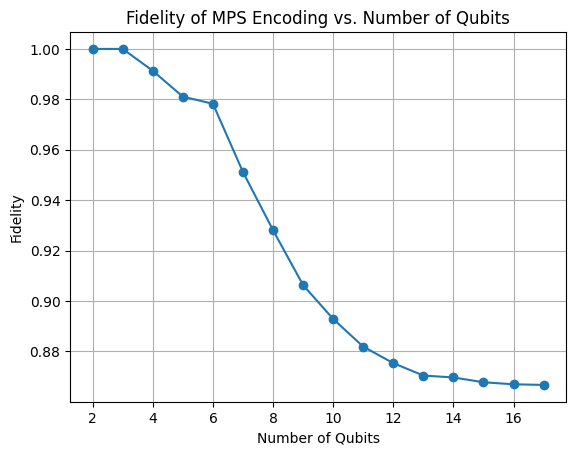

In [9]:
results = [mps_encoding_metadata(num_qubits) for num_qubits in range(2, 18)]

plt.plot(
    [result["num_qubits"] for result in results],
    [result["fidelity"] for result in results],
    marker="o",
)
plt.xlabel("Number of Qubits")
plt.ylabel("Fidelity")
plt.title("Fidelity of MPS Encoding vs. Number of Qubits")
plt.grid()
plt.show()

We can observe the massive difference between the exact approaches and MPS approach for this class of states in terms of circuit depth. With refinements from sweeping, this can be maintained whilst pushing fidelity to 0.97+ from the experimentation and even push it to perform as such on even volume-law entangled states.

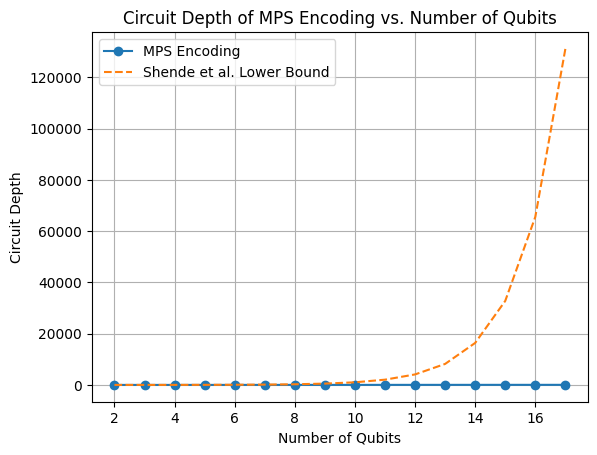

In [12]:
plt.plot(
    [result["num_qubits"] for result in results],
    [result["circuit_depth"] for result in results],
    marker="o",
    label="MPS Encoding",
)
plt.plot(
    [result["num_qubits"] for result in results],
    [2 ** result["num_qubits"] for result in results],
    linestyle="--",
    label="Shende et al. Lower Bound",
)
plt.xlabel("Number of Qubits")
plt.ylabel("Circuit Depth")
plt.title("Circuit Depth of MPS Encoding vs. Number of Qubits")
plt.legend()
plt.grid()
plt.show()

Overall, MPS IR is a critical step forward for efficient synthesis of statevectors, and makes a major difference for current term and 2030's onward FTQC hardware.

Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).